# Определение выгодного тарифа для телеком-компании

**Описание данных**, с которыми проводится работа:
- **таблица `users`** (информация о пользователях):

`user_id` — уникальный идентификатор пользователя

`first_name` — имя пользователя

`last_name` — фамилия пользователя

`age` — возраст пользователя (годы)

`reg_date` — дата подключения тарифа (день, месяц, год)

`churn_date` — дата прекращения пользования тарифом

`city` — город проживания пользователя

`tarif` — название тарифного плана

- **Таблица `calls`** (информация о звонках):

`id` — уникальный номер звонка

`call_date` — дата звонка

`duration` — длительность звонка в минутах

`user_id` — идентификатор пользователя, сделавшего звонок

- **Таблица `messages`** (информация о сообщениях):

`id` — уникальный номер звонка

`message_date` — дата сообщения

`user_id` — идентификатор пользователя, отправившего сообщение

- **Таблица `internet`** (информация об интернет-сессиях):

`id` — уникальный номер сессии

`mb_used` — объём потраченного за сессию интернет-трафика (MB)

`session_date` — дата интернет-сессии

`user_id` — идентификатор пользователя

- **Таблица `tariffs`** (информация о тарифах):

`tariff_name` — название тарифа

`rub_monthly_fee` — ежемесячная абонентская плата в рублях

`minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату

`messages_included` — количество сообщений в месяц, включённых в абонентскую плату

`mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (MB)

`rub_per_minute` — стоимость минуты разговора сверх тарифного пакета

`rub_per_message` — стоимость отправки сообщения сверх тарифного пакета

`rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

<a id="step1"></a>
## Общая информация о данных

Импортируем библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

Считываем данные из 5 предоставленных файлов и изучаем информацию об этих датафреймах.

### Звонки

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


- Пропущенных значений нет.
- Необходимо преобразовать данные в столбце `call_date` в тип *datetime* вместо *object*.
- Необходимо добавить столбец `month`, поскольку эти данные понадобятся для дальнейшего анализа.
- Добавим также столбец `duration_round`, поскольку известно, что "Мегалайн" всегда округляет секунды до минуты. А значит, в столбце должны быть округленные в б*о*льшую сторону числа.
- Столбец `id` содержит уникальный номер для звонка, но является по сути комбинацией номера звонка для строки с конкретным идентификатором пользователя `user_id`. Для упрощения последующей обработки данных создадим новый столбец с порядковым номером звонка и удалим прежний столбец.
- Присутствующая длительность звонков, равная 0 (значения в столбце `duration`), говорит о том, что звонок был, но разговор не состоялся, т.е. это был пропущенный звонок. То есть эти данные не являются ошибочными.

### Интернет-сессии

In [4]:
internet = pd.read_csv('/datasets/internet.csv')
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [5]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


- Пропущенных значений нет.
- Необходимо преобразовать данные в столбце `session_date` в тип *datetime* вместо *object*.
- Необходимо добавить столбец `month`, поскольку эти данные понадобятся для дальнейшего анализа.
- Столбец `Unnamed: 0` явно лишний, его можно удалить.
- Столбец `id` содержит уникальный номер для интернет-сессии, но является по сути комбинацией интернет-сессии для строки с конкретным идентификатором пользователя `user_id`. Для упрощения последующей обработки данных создадим новый столбец с порядковым номером интернет-сессии и удалим прежний столбец.
- Присутствующий нулевой трафик (значения в столбце `mb_used`) говорит о том, что при включенном интернете трафика по какой-то причине не было. То есть эти данные не являются ошибочными.

### Сообщения

In [6]:
messages = pd.read_csv('/datasets/messages.csv')
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [7]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


- Пропущенных значений нет.
- Необходимо преобразовать данные в столбце `message_date` в тип *datetime* вместо *object*.
- Необходимо добавить столбец `month`, поскольку эти данные понадобятся для дальнейшего анализа.
- Столбец `id` содержит уникальный номер для сообщения, но является по сути комбинацией сообщения для строки с конкретным идентификатором пользователя `user_id`. Для упрощения последующей обработки данных создадим новый столбец с порядковым номером сообщения и удалим прежний столбец.

### Тарифы

In [8]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [9]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


- Пропущенных значений нет.
- Добавим столбец `gb_per_month_included` для дальнейшего анализа данных.

### Пользователи

In [10]:
users = pd.read_csv('/datasets/users.csv')
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [11]:
users.info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


- Пропущенные значения есть в столбце `churn_date`, что означает, что тариф ещё действовал на момент выгрузки данных. Заполнять пропуски не будем.
- Необходимо преобразовать данные в столбцах `churn_date` и `reg_date` в тип *datetime* вместо *object*.
- Необходимо добавить столбец `month`, поскольку эти данные понадобятся для дальнейшего анализа.
- Изменим регистр городов и фамилии-имени на нижний.

### Вывод

- Считаны таблицы исходных данных. Проведен их первичный анализ.
- Выявлены пропущенные значения. Определены дальнейшие действия по их предобработке.
- Получена информация о размерах таблиц и типах данных.

<a id = 'step2'></a>
## Подготовка данных

### Предобработка и исправление ошибок в данных

Исправим типы данных там, где это необходимо. Для этого создадим функцию, которая будет изменять тип на *datetime* с учетом того, что формат даты во всех датафреймах одинаковый. И сразу же добавим столбец `month` в нужные датафреймы также с помощью созданной функции:

In [12]:
def date_change(df, row, new_row):
    df[row] = pd.to_datetime(df[row], format='%Y-%m-%d')
    df[new_row] = pd.DatetimeIndex(df[row]).month

In [13]:
date_change(calls, 'call_date', 'month')
date_change(internet, 'session_date', 'month')
date_change(messages, 'message_date', 'month')
date_change(users, 'churn_date', 'churn_month')
date_change(users, 'reg_date', 'reg_month')

Создадим новый столбец вместо `id` с порядковым номером звонка, сообщения и интернет-сессии и удалим прежний столбец. Также для этого напишем собственную функцию:

In [14]:
def id_int(df, column_name):
    df[column_name] = df['id'].str.split('_', n=1, expand=True)[1].astype('int')
    df.drop('id', axis=1, inplace=True)

In [15]:
id_int(calls, 'call_id')
id_int(internet, 'session_id')
id_int(messages, 'message_id')

Добавим столбец `duration_round` в датафрейм `calls`:

In [16]:
calls['duration_round'] = np.ceil(calls['duration']).astype(int)

Добавим столбец `gb_per_month_included` в датафрейм `tariffs`:

In [17]:
tariffs['gb_per_month_included'] = tariffs['mb_per_month_included'] / 1024



Изменим регистр городов и фамилии-имени на нижний тоже с помощью собственной функции:

In [18]:
def str_lower(df, row):
    df[row] = df[row].str.lower()

In [19]:
str_lower(users, 'city')
str_lower(users, 'first_name')
str_lower(users, 'last_name')

Проверим после всех правок датафреймы на дубликаты:

In [20]:
print('Дубликатов в звонках:', calls.duplicated().sum())
print('Дубликатов в интернет-сессиях:', internet.duplicated().sum())
print('Дубликатов в сообщениях:', messages.duplicated().sum())
print('Дубликатов в пользователях:', users.duplicated().sum())

Дубликатов в звонках: 0
Дубликатов в интернет-сессиях: 0
Дубликатов в сообщениях: 0
Дубликатов в пользователях: 0


In [21]:
internet.drop('Unnamed: 0', axis=1, inplace=True)

Посмотрим, что получилось по результатам предобработки данных:

In [22]:
calls.head(5)

,call_date,duration,user_id,month,call_id,duration_round
0,2018-07-25,0.00,1000,7,0,0
1,2018-08-17,0.00,1000,8,1,0
2,2018-06-11,2.85,1000,6,2,3
3,2018-09-21,13.80,1000,9,3,14
4,2018-12-15,5.18,1000,12,4,6


Рассмотрим информацию о параметрах данных, содержащихся в столбце `duration_round`:

In [23]:
calls['duration_round'].describe()

count    202607.000000
mean          7.158198
std           5.959173
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration_round, dtype: float64

Построим гистограмму по этому столбцу:

Text(0.5, 0, 'Duration')

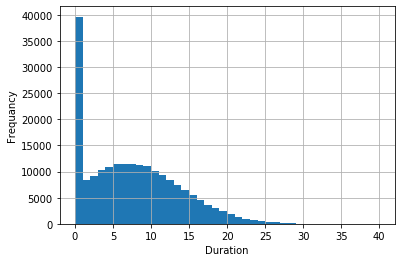

In [24]:
calls['duration_round'].hist(bins=40, range=(0,40))
plt.ylabel('Frequancy')
plt.xlabel('Duration')

In [25]:
len(calls.query('duration_round == 0'))

39613

Нулевая длительность звонков соответствует пропущенным звонкам. Доля таких звонков в наборе данных - почти 20%.

При этом эти нулевые длительности не являются ошибочными, которые нужно удалить или отправить по ним баг-репорт, и не являются пропущенными значениями, которые нужно чем-то заполнить.

Однако в дальнейших расчетах средних значений они внесут существенные искажения, сильно занизив результаты расчетов.

Чтобы этого избежать, отфильтруем нулевые значения.

In [26]:
calls_without_missed = calls.query('duration_round != 0')

Text(0.5, 0, 'Duration')

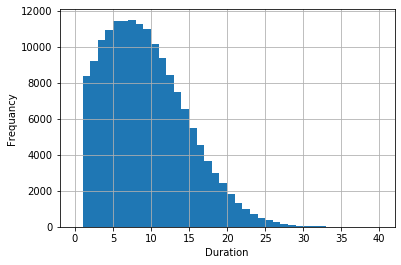

In [27]:
calls_without_missed['duration_round'].hist(bins=40, range=(0,40))
plt.ylabel('Frequancy')
plt.xlabel('Duration')

In [28]:
calls_without_missed['duration_round'].describe()

count    162994.000000
mean          8.897880
std           5.353761
min           1.000000
25%           5.000000
50%           8.000000
75%          12.000000
max          38.000000
Name: duration_round, dtype: float64

In [29]:
internet.sample(5)

,mb_used,session_date,user_id,month,session_id
44103,71.31,2018-03-10,1152,3,321
112908,859.09,2018-06-24,1381,6,497
45804,0.00,2018-10-02,1157,10,316
12442,0.00,2018-07-19,1044,7,79
134596,211.84,2018-08-06,1452,8,134


Рассмотрим информацию о параметрах данных, содержащихся в столбце `duration_round`:

In [30]:
internet['mb_used'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

Построим гистограмму по этому столбцу:

Text(0.5, 0, 'MB used')

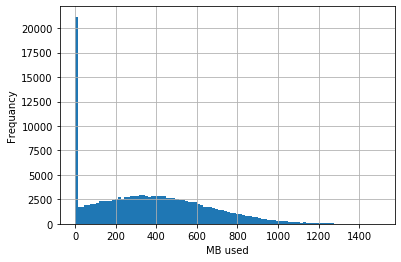

In [31]:
internet['mb_used'].hist(bins=100, range=(0, 1500))
plt.ylabel('Frequancy')
plt.xlabel('MB used')

In [32]:
len(internet.query('mb_used == 0'))

19598

Нулевой объем трафика интернет-сессий в наборе данных составляет почти 13%.

Вероятно, это интернет-сессии, при которых интернет был подключен, но трафика по нему не шло, т.е. онлайн активности пользователя не было.

*Эту догадку следует уточнить у тех, кто готовит данные.* 

А на данном этапе анализа отфильтруем нулевые значения интернет-трафика, чтобы они тоже не вносили искажения в дальнейшие исследования:

In [33]:
internet_success = internet.query('mb_used != 0')

Text(0.5, 0, 'MB used')

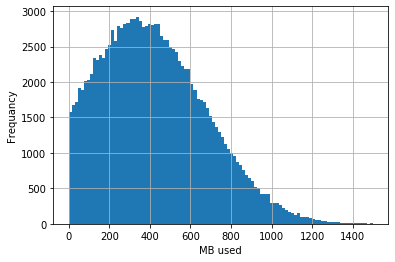

In [34]:
internet_success['mb_used'].hist(bins=100, range=(0, 1500))
plt.ylabel('Frequancy')
plt.xlabel('MB used')

In [35]:
internet_success['mb_used'].describe()

count    129798.000000
mean        426.087210
std         255.596447
min           0.030000
25%         227.460000
50%         400.540000
75%         592.947500
max        1724.830000
Name: mb_used, dtype: float64

In [36]:
messages.sample(5)

,message_date,user_id,month,message_id
114096,2018-11-29,1464,11,230
81705,2018-12-28,1342,12,160
99160,2018-12-10,1404,12,300
75318,2018-10-17,1318,10,347
18255,2018-12-19,1080,12,201


In [37]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15.0
1,1000,30720,3000,1950,150,1,1,ultra,30.0


In [38]:
users.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,churn_month,reg_month
0,1000,52,NaT,краснодар,рафаил,верещагин,2018-05-25,ultra,NaN,5
1,1001,41,NaT,москва,иван,ежов,2018-11-01,smart,NaN,11
2,1002,59,NaT,стерлитамак,евгений,абрамович,2018-06-17,smart,NaN,6
3,1003,23,NaT,москва,белла,белякова,2018-08-17,ultra,NaN,8
4,1004,68,NaT,новокузнецк,татьяна,авдеенко,2018-05-14,ultra,NaN,5


Оценим, сколько в выборке пользователей по каждому тарифу:

In [39]:
len(users.query('tariff == "smart"'))

351

In [40]:
len(users.query('tariff == "ultra"'))

149

### Расчеты и добавление данных

Для каждого пользователя произведем дополнительные расчеты:

**2.2.1.** Посчитаем количество сделанных звонков по месяцам, включая пропущенные. Для этого нужно сгруппировать данные по `user_id` и `month` (категория и субкатегория) и найти количество значений по `call_id`. Сделаем это с помощью сводных таблиц и избавимся от мультииндекса:

In [41]:
calls_pivot = calls_without_missed.pivot_table(index=['user_id', 'month'], values='call_id', aggfunc='count')
calls_pivot_with_reset_index = calls_pivot.reset_index()

**2.2.2.** Подобным образом подсчитаем количество (сумму) израсходованных минут разговора по месяцам:

In [42]:
minutes_pivot = calls_without_missed.pivot_table(index=['user_id', 'month'], values='duration_round', aggfunc='sum')
minutes_pivot_with_reset_index = minutes_pivot.reset_index()

**2.2.3.** Посчитаем количество отправленных сообщений по месяцам:

In [43]:
messages_pivot = messages.pivot_table(index=['user_id', 'month'], values='message_id', aggfunc='count')
messages_pivot_with_reset_index = messages_pivot.reset_index()

**2.2.4.** Посчитаем объем израсходованного интернет-трафика по месяцам:

In [44]:
internet_pivot = internet_success.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc ='sum')
internet_pivot_with_reset_index = internet_pivot.reset_index()

In [45]:
internet_pivot_with_reset_index['gb_month_round'] = np.ceil(internet_pivot_with_reset_index['mb_used'] / 1024).astype(int)

**2.2.5.** Посчитаем помесячную выручку с каждого пользователя. При этом вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика, остаток умножим на значение из тарифного плана и прибавим абонентскую плату, соответствующую тарифному плану.

Но для начала составим таблицу, которая будет содержать информацию о пользователях, тарифах и объемах расходов минут, сообщений и трафика:

In [46]:
data_analysis = calls_pivot_with_reset_index.merge(minutes_pivot_with_reset_index, on=['user_id', 'month'], how='outer')

In [47]:
data_analysis = data_analysis.merge(messages_pivot_with_reset_index, on=['user_id', 'month'], how='outer')

In [48]:
data_analysis = data_analysis.merge(internet_pivot_with_reset_index, on=['user_id', 'month'], how='outer')

Добавим столбец с тарифом из датафрейма `users` для каждого пользователя по значению `user_id`:

In [49]:
data_analysis = data_analysis.merge(users[['user_id','tariff','city']], on='user_id', how='outer')

Таблица для анализа данных без лишней информации приобрела вид:

In [50]:
data_analysis.head(5)

,user_id,month,call_id,duration_round,message_id,mb_used,gb_month_round,tariff,city
0,1000,5.0,17.0,159.0,22.0,2253.49,3.0,ultra,краснодар
1,1000,6.0,28.0,172.0,60.0,23233.77,23.0,ultra,краснодар
2,1000,7.0,41.0,340.0,75.0,14003.64,14.0,ultra,краснодар
3,1000,8.0,42.0,408.0,81.0,14055.93,14.0,ultra,краснодар
4,1000,9.0,46.0,466.0,57.0,14568.91,15.0,ultra,краснодар


In [51]:
data_analysis.describe()

,user_id,month,call_id,duration_round,message_id,mb_used,gb_month_round
count,3216.000000,3214.000000,3168.000000,3168.000000,2717.000000,3201.000000,3201.000000
mean,1251.588930,8.317362,51.450126,457.797033,45.283769,17277.496948,17.369260
std,144.645928,2.905413,26.439188,237.423514,35.051363,7506.295851,7.332836
min,1000.000000,1.000000,1.000000,1.000000,1.000000,201.070000,1.000000
25%,1125.000000,6.000000,33.000000,290.750000,19.000000,12550.910000,13.000000
50%,1253.000000,9.000000,50.000000,447.500000,38.000000,16963.980000,17.000000
75%,1378.250000,11.000000,67.000000,592.250000,63.000000,21436.370000,21.000000
max,1499.000000,12.000000,190.000000,1673.000000,224.000000,49745.690000,49.000000


**Анализ параметров таблицы говорит о том, что данные хорошо отфильтрованы: в них отсутствуют выбросы (т.к. средние значения и медианы достаточно близки по величине) и нулевые значения.**

Создадим собственные функции для подсчета выручки за каждый пакет услуг:

In [52]:
def minutes_income(row):
    minutes = row['duration_round']
    tariff = row['tariff']
    if (tariff == 'smart'):
        tariff_index = 0
    else:
        tariff_index = 1
    minutes_remainder = tariffs['minutes_included'][tariff_index] - minutes
    if minutes_remainder < 0:
        minutes_money = abs(minutes_remainder) * tariffs['rub_per_minute'][tariff_index]
    else:
        minutes_money = 0
    return minutes_money

In [53]:
data_analysis['calls_income'] = data_analysis.apply(minutes_income, axis=1)

In [54]:
def messages_income(row):
    messages = row['message_id']
    tariff = row['tariff']
    if (tariff == 'smart'):
        tariff_index = 0
    else:
        tariff_index = 1
    messages_remainder = tariffs['messages_included'][tariff_index] - messages
    if messages_remainder < 0:
        messages_money = abs(messages_remainder) * tariffs['rub_per_message'][tariff_index]
    else:
        messages_money = 0
    return messages_money

In [55]:
data_analysis['messages_income'] = data_analysis.apply(messages_income, axis=1)

In [56]:
def internet_income(row):
    internet = row['gb_month_round']
    tariff = row['tariff']
    if (tariff == 'smart'):
        tariff_index = 0
    else:
        tariff_index = 1
    internet_remainder = tariffs['gb_per_month_included'][tariff_index] - internet
    if internet_remainder < 0:
        internet_money = abs(internet_remainder) * tariffs['rub_per_gb'][tariff_index]
    else:
        internet_money = 0
    return internet_money

In [57]:
data_analysis['internet_income'] = data_analysis.apply(internet_income, axis=1)

Теперь учтем абонентскую плату согласно тарифу и просуммируем ее со стоимостью фактически потраченных пакетов услуг. Сделаем это также с помощью пользовательской функции:

In [58]:
def total_income(row):
    calls = row['calls_income']
    messages = row['messages_income']
    internet = row['internet_income']
    tariff = row['tariff']
    if (tariff == 'smart'):
        tariff_index = 0
    else:
        tariff_index = 1
    total = tariffs['rub_monthly_fee'][tariff_index] + calls + messages + internet
    return total

In [59]:
data_analysis['total_income'] = data_analysis.apply(total_income, axis=1)

In [60]:
data_analysis.sample(10)

,user_id,month,call_id,duration_round,message_id,mb_used,gb_month_round,tariff,city,calls_income,messages_income,internet_income,total_income
1761,1282,7.0,82.0,748.0,64.0,13229.40,13.0,smart,ульяновск,744.0,42.0,0.0,1336.0
387,1061,10.0,64.0,588.0,9.0,16601.99,17.0,smart,санкт-петербург,264.0,0.0,400.0,1214.0
1396,1221,11.0,38.0,348.0,26.0,8376.60,9.0,smart,белгород,0.0,0.0,0.0,550.0
2181,1350,9.0,40.0,303.0,42.0,18679.34,19.0,ultra,омск,0.0,0.0,0.0,1950.0
2633,1415,6.0,5.0,43.0,3.0,2538.67,3.0,ultra,москва,0.0,0.0,0.0,1950.0
1589,1254,6.0,61.0,562.0,NaN,22924.77,23.0,ultra,москва,0.0,0.0,0.0,1950.0
2288,1367,9.0,35.0,318.0,NaN,11486.65,12.0,ultra,москва,0.0,0.0,0.0,1950.0
2119,1338,10.0,20.0,186.0,34.0,17166.42,17.0,smart,москва,0.0,0.0,400.0,950.0
2303,1370,8.0,14.0,123.0,NaN,18743.46,19.0,smart,новороссийск,0.0,0.0,800.0,1350.0
2749,1431,4.0,29.0,266.0,72.0,19921.77,20.0,smart,уфа,0.0,66.0,1000.0,1616.0


In [61]:
data_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 13 columns):
user_id            3216 non-null int64
month              3214 non-null float64
call_id            3168 non-null float64
duration_round     3168 non-null float64
message_id         2717 non-null float64
mb_used            3201 non-null float64
gb_month_round     3201 non-null float64
tariff             3216 non-null object
city               3216 non-null object
calls_income       3216 non-null float64
messages_income    3216 non-null float64
internet_income    3216 non-null float64
total_income       3216 non-null float64
dtypes: float64(10), int64(1), object(2)
memory usage: 351.8+ KB


### Вывод

- Проведена предобработка данных: удалены лишние столбцы; изменены типы данных; изменен регистр в данных типа `object`; отфильтрованы нулевые значения.
- Проведен расчет и добавлены новые столбцы, которые содержат информацию, необходимую для дальнейшего исследования.
- Создана таблица `data_analisys`, содержащая "интегрирующие" данные для исследовательского анализа.

<a id='step3'></a>
## Анализ данных по тарифам

Определим среднее количество минут разговора, сообщений и объем интернет-трафика пользователей каждого тарифа в месяц. Построим гистограммы. Опишем распределения.

При этом следует помнить, что:
- *дисперсия* характеризует меру разброса величины около ее среднего значения, то есть это мера рассеивания данных;
- *среднеквадратическое отклонение (СКО)* определяет, на сколько каждое значение выборки в среднем отличается от среднего значения выборки.

### Количество минут разговора по тарифам

Создадим сводную таблицу, которая будет отображать среднее количество минут разговора по каждому тарифу в месяц по всем пользователям:

In [62]:
mean_calls_per_month = data_analysis.pivot_table(
    index='month',
    columns='tariff',
    values='duration_round',
    aggfunc='mean'
).reset_index().round(0).astype(int)

In [63]:
mean_calls_per_month

tariff,month,smart,ultra
0,1,210,428
1,2,299,310
2,3,390,490
3,4,370,475
4,5,387,534
5,6,398,497
6,7,408,571
7,8,423,536
8,9,430,564
9,10,428,582


Построитм столбчатую диаграмму, визуализирующую полученные результаты:

Text(0.5, 1.0, 'Среднее количество минут разговоров по тарифам')

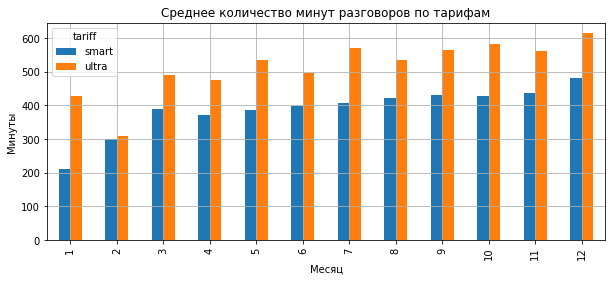

In [64]:
mean_calls_per_month.plot.bar(x='month', figsize=(10,4), grid=True)
plt.xlabel('Месяц')
plt.ylabel('Минуты')
plt.title('Среднее количество минут разговоров по тарифам')

Рассчитаем центральную метрику (среднее значение) данных по звонкам для двух тарифов и метрики оценки вариативности данных (дисперсию и СКО), которые количественно определяют разброс данных:

In [65]:
mean_calls_smart = np.mean(data_analysis.query('tariff == "smart"')['duration_round']).round(2)
mean_calls_ultra = np.mean(data_analysis.query('tariff == "ultra"')['duration_round']).round(2)
print('Средняя длительность звонков в выборке для тарифа Smart:', mean_calls_smart)
print('Средняя длительность звонков в выборке для тарифа Ultra:', mean_calls_ultra)

Средняя длительность звонков в выборке для тарифа Smart: 419.44
Средняя длительность звонков в выборке для тарифа Ultra: 547.76


In [66]:
variance_calls_smart = np.var(data_analysis.query('tariff == "smart"')['duration_round'], ddof=1).round(2)
variance_calls_ultra = np.var(data_analysis.query('tariff == "ultra"')['duration_round'], ddof=1).round(2)
print('Дисперсия длительности звонков в выборке для тарифа Smart:', variance_calls_smart)
print('Дисперсия длительности звонков в выборке для тарифа Ultra:', variance_calls_ultra)

Дисперсия длительности звонков в выборке для тарифа Smart: 35718.13
Дисперсия длительности звонков в выборке для тарифа Ultra: 93338.43


In [67]:
st_dev_calls_smart = np.std(data_analysis.query('tariff == "smart"')['duration_round'], ddof=1).round(2)
st_dev_calls_ultra = np.std(data_analysis.query('tariff == "ultra"')['duration_round'], ddof=1).round(2)
print('СКО длительности звонков в выборке для тарифа Smart:', st_dev_calls_smart)
print('СКО длительности звонков в выборке для тарифа Ultra:', st_dev_calls_ultra)

СКО длительности звонков в выборке для тарифа Smart: 188.99
СКО длительности звонков в выборке для тарифа Ultra: 305.51


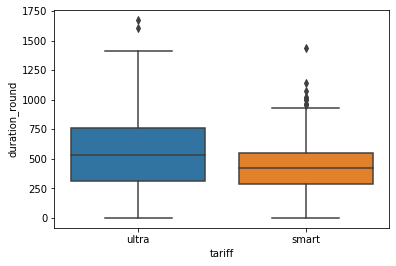

In [68]:
sns.boxplot(y='duration_round', x='tariff', data=data_analysis)

### Количество сообщений по тарифам

Аналогичным образом обработаем данные по сообщениям:

In [69]:
mean_messages_per_month = data_analysis.pivot_table(
    index='month',
    columns='tariff',
    values='message_id',
    aggfunc='mean'
).reset_index().round(0).astype(int)

In [70]:
mean_messages_per_month

tariff,month,smart,ultra
0,1,20,43
1,2,28,33
2,3,36,48
3,4,36,45
4,5,39,49
5,6,39,52
6,7,39,62
7,8,39,59
8,9,39,63
9,10,39,70


Text(0.5, 1.0, 'Среднее количество сообщений по тарифам')

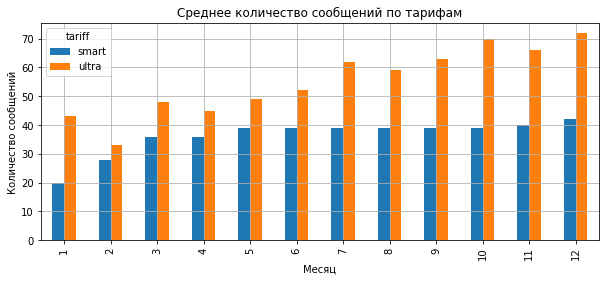

In [71]:
mean_messages_per_month.plot.bar(x='month', figsize=(10,4), grid=True)
plt.xlabel('Месяц')
plt.ylabel('Количество сообщений')
plt.title('Среднее количество сообщений по тарифам')

Рассчитаем центральную метрику (среднее значение) данных по сообщениям для двух тарифов и метрики оценки вариативности данных (дисперсию и СКО), которые количественно определяют разброс точек данных:

In [72]:
mean_messages_smart = np.mean(data_analysis.query('tariff == "smart"')['message_id']).round(2)
mean_messages_ultra = np.mean(data_analysis.query('tariff == "ultra"')['message_id']).round(2)
print('Среднее количество сообщений в выборке для тарифа Smart:', mean_messages_smart)
print('Среднее количество сообщений в выборке для тарифа Ultra:', mean_messages_ultra)

Среднее количество сообщений в выборке для тарифа Smart: 38.72
Среднее количество сообщений в выборке для тарифа Ultra: 61.16


In [73]:
variance_messages_smart = np.var(data_analysis.query('tariff == "smart"')['message_id'], ddof=1).round(2)
variance_messages_ultra = np.var(data_analysis.query('tariff == "ultra"')['message_id'], ddof=1).round(2)
print('Дисперсия количества сообщений в выборке для тарифа Smart:', variance_messages_smart)
print('Дисперсия количества сообщений в выборке для тарифа Ultra:', variance_messages_ultra)

Дисперсия количества сообщений в выборке для тарифа Smart: 717.59
Дисперсия количества сообщений в выборке для тарифа Ultra: 2109.66


In [74]:
st_dev_messages_smart = np.std(data_analysis.query('tariff == "smart"')['message_id'], ddof=1).round(2)
st_dev_messages_ultra = np.std(data_analysis.query('tariff == "ultra"')['message_id'], ddof=1).round(2)
print('СКО количества сообщений в выборке для тарифа Smart:', st_dev_messages_smart)
print('СКО количества сообщений в выборке для тарифа Ultra:', st_dev_messages_ultra)

СКО количества сообщений в выборке для тарифа Smart: 26.79
СКО количества сообщений в выборке для тарифа Ultra: 45.93


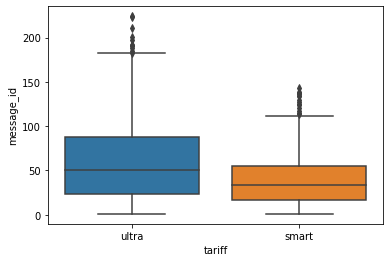

In [75]:
sns.boxplot(y='message_id', x='tariff', data=data_analysis)

### Объем интернет-трафика по тарифам

Аналогичным образом обработаем данные по интернет-трафику:

In [76]:
mean_internet_per_month = data_analysis.pivot_table(
    index='month',
    columns='tariff',
    values='gb_month_round',
    aggfunc='mean'
).reset_index().round(0).astype(int)

In [77]:
mean_internet_per_month

tariff,month,smart,ultra
0,1,9,13
1,2,12,13
2,3,15,18
3,4,14,17
4,5,16,20
5,6,16,19
6,7,16,21
7,8,17,20
8,9,16,19
9,10,17,20


Text(0.5, 1.0, 'Средний объем трафика по тарифам')

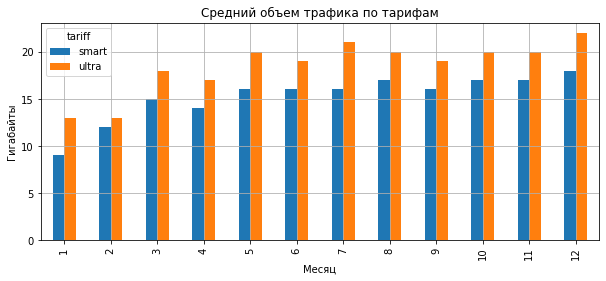

In [78]:
mean_internet_per_month.plot.bar(x='month', figsize=(10,4), grid=True)
plt.xlabel('Месяц')
plt.ylabel('Гигабайты')
plt.title('Средний объем трафика по тарифам')

Рассчитаем центральную метрику (среднее значение) данных по интернет-трафику для двух тарифов и метрики оценки вариативности данных (дисперсию и СКО), которые количественно определяют разброс точек данных:

In [79]:
mean_internet_smart = np.mean(data_analysis.query('tariff == "smart"')['gb_month_round']).round(2)
mean_internet_ultra = np.mean(data_analysis.query('tariff == "ultra"')['gb_month_round']).round(2)
print('Средний объем трафика в выборке для тарифа Smart:', mean_internet_smart)
print('Средний объем трафика в выборке для тарифа Ultra:', mean_internet_ultra)

Средний объем трафика в выборке для тарифа Smart: 16.34
Средний объем трафика в выборке для тарифа Ultra: 19.71


In [80]:
variance_internet_smart = np.var(data_analysis.query('tariff == "smart"')['gb_month_round'], ddof=1).round(2)
variance_internet_ultra = np.var(data_analysis.query('tariff == "ultra"')['gb_month_round'], ddof=1).round(2)
print('Дисперсия интернет-трафика в выборке для тарифа Smart:', variance_internet_smart)
print('Дисперсия интернет-трафика в выборке для тарифа Ultra:', variance_internet_ultra)

Дисперсия интернет-трафика в выборке для тарифа Smart: 32.82
Дисперсия интернет-трафика в выборке для тарифа Ultra: 93.84


In [81]:
st_dev_internet_smart = np.std(data_analysis.query('tariff == "smart"')['gb_month_round'], ddof=1).round(2)
st_dev_internet_ultra = np.std(data_analysis.query('tariff == "ultra"')['gb_month_round'], ddof=1).round(2)
print('СКО интернет-трафика в выборке для тарифа Smart:', st_dev_internet_smart)
print('СКО интернет-трафика в выборке для тарифа Ultra:', st_dev_internet_ultra)

СКО интернет-трафика в выборке для тарифа Smart: 5.73
СКО интернет-трафика в выборке для тарифа Ultra: 9.69


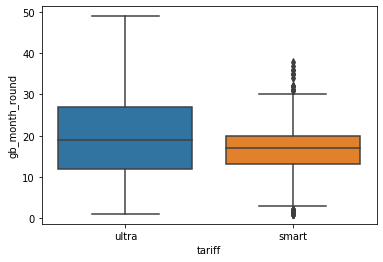

In [82]:
sns.boxplot(y='gb_month_round', x='tariff', data=data_analysis)

### Помесячная выручка по тарифам

Аналогичным образом посчитаем помесячную выручку по двум тарифам.

In [83]:
mean_income_per_month = data_analysis.pivot_table(
    index='month',
    columns='tariff',
    values='total_income',
    aggfunc='mean'
).reset_index().round(0).astype(int)

In [84]:
mean_income_per_month

tariff,month,smart,ultra
0,1,721,1950
1,2,828,1975
2,3,1165,2015
3,4,963,2002
4,5,1198,2060
5,6,1204,2039
6,7,1224,2118
7,8,1321,2083
8,9,1250,2024
9,10,1365,2066


Text(0.5, 1.0, 'Средняя выручка по тарифам')

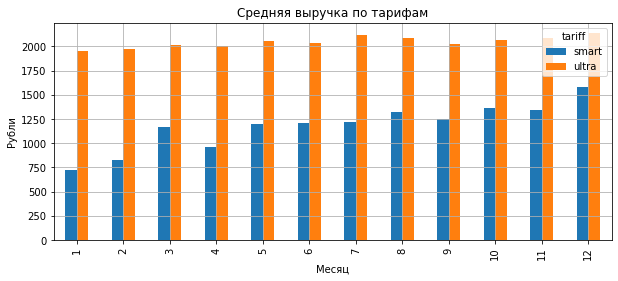

In [85]:
mean_income_per_month.plot.bar(x='month', figsize=(10,4), grid=True)
plt.xlabel('Месяц')
plt.ylabel('Рубли')
plt.title('Средняя выручка по тарифам')

### Вывод

- В среднем пользователи тарифа **"Ультра" разговаривают больше**, чем пользователи тарифа "Смарт". При этом и те, и другие укладываются в оплаченный по абонентской плате тарифов пакет минут. Также следует отметить, что разброс данных у пользователей тарифом "Ультра" больше.
- **Сообщениями** обмениваются пользователи тарифа **"Ультра" также в среднем больше**, чем пользователи тарифа "Смарт". Однако так же им хватает своих предоплаченных пакетов сообщений. Разброс данных у пользователей тарифом "Ультра" снова больше.
- **Интернетом** пользователи тарифа **"Ультра" тоже пользуются больше**, чем пользователи тарифа "Смарт". При этом последние не укладываются в пакет и оплачивает его ежемесячно сверх абонентской платы. Средние значения близки, но дисперсия для тарифа "Ультра" больше, хотя и незначительно.
- В среднем **выручка по тарифу "Ультра" больше**, чем по тарифу "Смарт". Однако ее величина не сильно отличается от абоненсткой платы. А по тарифу "Смарт" превышение абонентской платы в среднем гораздо существеннее в каждом месяце, иногда более чем в 3 раза. При этом по тарифу "Смарт" выручка по месяцам растет к концу года: в основном за счет увеличения длительности разгоров, а у пользователей тарифа "Ультра" она меняется не существенно в течение года.

<a id='step4'></a>
## Проверка статистических гипотез

### Различие выручки по тарифам

Проверим гипотезу о том, что средняя выручка пользователей тарифов "Ультра" и "Смарт" различается.

Для этого сформулируем нулевую гипотезу H0: средние выручки пользователей тарифов "Ультра" и "Смарт" равны.

Тогда альтернативная гипотеза H1 будет звучать так: средние выручки пользователей тарифов "Ультра" и "Смарт" не равны.

Создадим два объекта `series`, содержащих данные о выручке по каждому тарифу. Это и будут исходные выборки:

In [86]:
sample_smart = data_analysis.query('tariff == "smart"')['total_income']

In [87]:
sample_ultra = data_analysis.query('tariff == "ultra"')['total_income']

Оценим дисперсии двух выборок. Если дисперсии будет отличаться более чем на 5%, то будем считать, что генеральные совокупности, из которых взяты эти выборки, отличаются по параметрам и тогда будем задавать в функции `st.ttest_ind` параметр `equal_var=False`.

In [88]:
variance_sample_smart = np.var(sample_smart, ddof=1).round(2)
variance_sample_ultra = np.var(sample_ultra, ddof=1).round(2)
print('Дисперсия выборки sample_smart:', variance_sample_smart)
print('Дисперсия выборки sample_ultra:', variance_sample_ultra)
diff = (variance_sample_smart - variance_sample_ultra) * 100 / variance_sample_smart
print(f'Дисперсии двух выборок отличаются на {abs(diff):.2f}%')

Дисперсия выборки sample_smart: 669730.76
Дисперсия выборки sample_ultra: 141387.71
Дисперсии двух выборок отличаются на 78.89%


Зададим пороговое значение *alpha* равным 0.01. Это означает, что будем проверять гипотезу о равенстве средних значений этих выборок на 99% уровне доверия:

In [89]:
alpha = 0.01

Воспользуемся встроенными в *Python* функциями для проверки статистических гипотез:

In [90]:
results = st.ttest_ind (sample_smart, sample_ultra, equal_var=False)

In [91]:
print('p-значение:', results.pvalue)

p-значение: 1.927011394420941e-250


In [92]:
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Отвергаем нулевую гипотезу


**Вывод**

Результаты статистического анализа показали, что при 1% уровне значимости нулевая гипотеза о равенстве средней выручки по двум тарифам отвергается. Это означает, что *средние значения выручки по тарифам существенно отличаются*.

### Различие выручки по Москве и регионам

Проверим гипотезу о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Для этого сформулируем нулевую гипотезу H0: средние выручки пользователей из Москвы и регионов равны.

Тогда альтернативная гипотеза H1 будет звучать так: средние выручки пользователей из Москвы и регионов не равны.

Создадим два объекта `series`, содержащих данные о выручке по Москве и остальным городам. Это и будут исходные выборки:

In [93]:
sample_moscow = data_analysis.query('city == "москва"')['total_income']

In [94]:
sample_city = data_analysis.query('city != "москва"')['total_income']

Оценим дисперсии двух выборок. Если дисперсии будет отличаться более чем на 5%, то будем считать, что генеральные совокупности, из которых взяты эти выборки, отличаются по параметрам.

In [95]:
variance_sample_moscow = np.var(sample_moscow, ddof=1).round(2)
variance_sample_city = np.var(sample_city, ddof=1).round(2)
print('Дисперсия выборки sample_moscow:', variance_sample_moscow)
print('Дисперсия выборки sample_city:', variance_sample_city)
diff = (variance_sample_moscow - variance_sample_city) * 100 / variance_sample_moscow
print(f'Дисперсии двух выборок отличаются на {abs(diff):.2f}%')

Дисперсия выборки sample_moscow: 565636.47
Дисперсия выборки sample_city: 654069.57
Дисперсии двух выборок отличаются на 15.63%




Зададим пороговое значение *alpha* равным 0.01. Это означает, что будем проверять гипотезу о равенстве средних значений этих выборок на 99% уровне доверия:

In [96]:
alpha = 0.01

In [97]:
results = st.ttest_ind (sample_moscow, sample_city, equal_var=False)

In [98]:
print('p-значение:', results.pvalue)

p-значение: 0.5216952110000279


In [99]:
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Не получилось отвергнуть нулевую гипотезу


**Вывод**

Результаты статистического анализа показали, что при 1% уровне значимости нулевая гипотеза о равенстве средней выручки по Москве и другим городам не отвергается. Это означает, что *средние значения выручки по Москве и регионам с высокой вероятностью равны*.

<a id='step5'></a>
## Общий вывод

Проведен исследовательский и статистический анализ данных о пользовании услугами связи по двум тарифам на выборке из 500 клиентов. Анализ показал, что:
- в среднем пользователи тарифа **"Ультра" разговаривают и обмениваются сообщениями больше**, чем пользователи тарифа "Смарт". Однако пользователи обоих тарифов по данным услугам *укладываются в оплаченные по абонентской плате пакеты* услуг.
- **Интернет-трафик** пользователей тарифа **"Ультра" больше**, чем пользователей тарифа "Смарт". Однако на *тарифе "Смарт" в среднем ежемесячно трафик превышает оплаченный пакет*.
- В среднем ежемесячная **выручка по тарифу "Ультра" больше**, чем по тарифу "Смарт", однако ее величина не сильно отличается от абоненсткой платы. А по тарифу "Смарт" превышение абонентской платы в среднем гораздо существеннее в каждом месяце, иногда более чем в 3 раза.
- **По географическому признаку средние значения выручки не отличаются** существенно.

Всё это позволяет сделать вывод о том, что **тариф "Ультра" приносит компании "Мегалайн" больше денег** по сравнению с тарифом "Смарт" независимо от региона пользователя и несмотря на то, что по тарифу "Смарт" чаще оплачиваются услуги сверх входящих в тариф предоплаченных пакетов.